# Outlier Detection in Power Consumption Data via Forecast Error

### Authors: 
#### [Gustavo Felipe MARTIN NASCIMENTO](http://lattes.cnpq.br/7822903280012578) - [GRUCAD/EEL/UFSC](https://grucad.ufsc.br/) - [G2ELab/Grenoble-INP/UGA](https://g2elab.grenoble-inp.fr/)
####                 [Frédéric WURTZ](https://www.researchgate.net/profile/Frederic_Wurtz) - [G2ELab/Grenoble-INP/UGA](https://g2elab.grenoble-inp.fr/)
####                 [Benoît DELINCHANT](https://www.researchgate.net/profile/Benoit_Delinchant) - [G2ELab/Grenoble-INP/UGA](https://g2elab.grenoble-inp.fr/)
####                [Patrick KUO-PENG](http://lattes.cnpq.br/9920822116918042) - [GRUCAD/EEL/UFSC](https://grucad.ufsc.br/)
####                 [Nelson JHOE BATISTELA](http://lattes.cnpq.br/5387328100140459) - [GRUCAD/EEL/UFSC](https://grucad.ufsc.br/)
![title](images_outliers/logos.jpg)

#### This IPython Notebook presents the code used to detect outliers in the power consumption data from the GreEn-ER building. A tertiary building located in Grenoble - France.

##### Importing libraries

In [1]:
#Import python libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib notebook

##### Importing scripts

In [2]:
#Imports function to calculate the error metrics of the forecast results
from outdet.error_metrics import metrics_error

#Import function to plot the actual consumption and the forecast results
from outdet.plot_pred import plot_predict

#Import Function to calculate bounderies and number of outliers by each used method
from outdet.statistic_out_det import limites
from outdet.statistic_out_det import detection

#Import function to load and pre-process GreEn-ER global consumption data
from outdet.pre_processing import open_data

#Import function to plot data with 
from outdet.plot_error import plot_error_upper
from outdet.plot_error import plot_error_lower

# Pre-processing data

### This notebook explores two time series

#### - Adapted Data - Measurements Pre-processed, without outliers 
#### - Adapted Data With Outliers - Adapted Data with 12 outliers inserted manually


#### In order to open each one of the series, we need to input the following commands:
#### - Adapted Data - Adapted 
#### - Adapted Data With Outliers - Adapted With Outliers

In [72]:
#Loading and pre-processing data
entry=str('Adapted With Outliers')
data,GT_out=open_data(entry,2017)


<IPython.core.display.Javascript object>


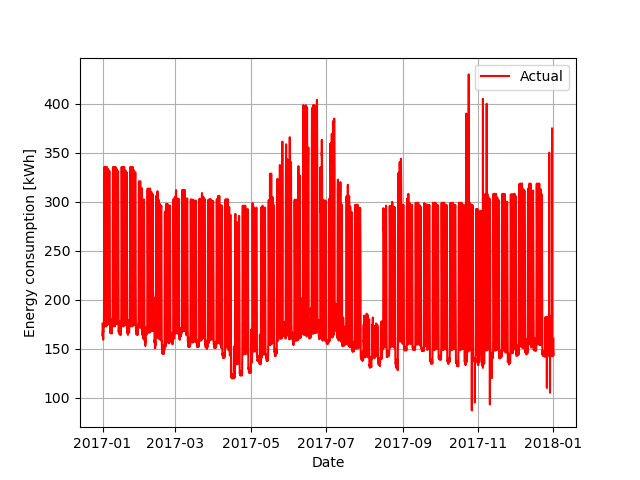

In [16]:
#Plotting the Actual Consumption
plt.figure()
plt.plot(data.index,data['Actual'],'r')
plt.legend(['Actual'])
plt.xlabel('Date')
plt.ylabel('Energy consumption [kWh]')
plt.grid(True)

In [5]:
#Getting columns names
#Actual is the measured consumption
#The other columns are the data features
print(data.columns.values.tolist())

['Temperature', 'T_avg', 'HourOfDay', 'DayOfWeek', 'DayOfYear', 'Month', 'Holiday', 'Actual', 'Outliers']


In [ ]:
data

<IPython.core.display.Javascript object>


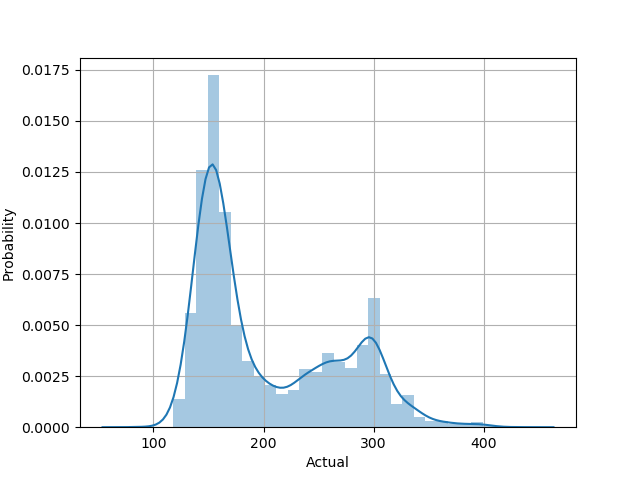

Text(0, 0.5, 'Probability')

In [6]:
#Plotting the data distribution
plt.figure()
sns.distplot(data['Actual'])
plt.grid(True)
plt.ylabel('Probability')

# Using Machine Learning to predict electricity consumption

In [7]:
#Set the trainning data

#gets rid of data with numerous outliers to train the model without these anomalies 
#data_train=data[240:]
data_train=data

#Sets the train data features
X_tr=data_train.drop(['Actual','Outliers'],axis=1)

#Sets the train data target
Y_tr=data_train['Actual']

#Sets Target Values of test data (measured consumption)
Y1=data['Actual']

#Sets Features the test data 
X1=data.drop(['Actual','Outliers'],axis=1)

In [8]:
#Import train-test split function
from sklearn.model_selection import train_test_split
#Sets X and Y test as all avaiable data for 2017
y_test=Y1
X_test=X1

#Splits the train data
#Gets 50% of the samples in a randomly
X_train, X_testi, y_train, y_testi = train_test_split(
    X_tr, Y_tr, train_size=0.8,shuffle=False)

## Random Forest

#### Using the Random Forest method to obtain a model from the training dataset and forecasting the consumption for the test data

In [9]:
#Import Random Forest regressor
from sklearn.ensemble import RandomForestRegressor

#Choosing number of trees
n_esti=100
rf = RandomForestRegressor(n_estimators= n_esti)

#Train the model with fit function and trainning data
rf.fit(X_train, y_train);

#Predict consumption using fit model and features of test data
predictions_rf = rf.predict(X_test)

<IPython.core.display.Javascript object>


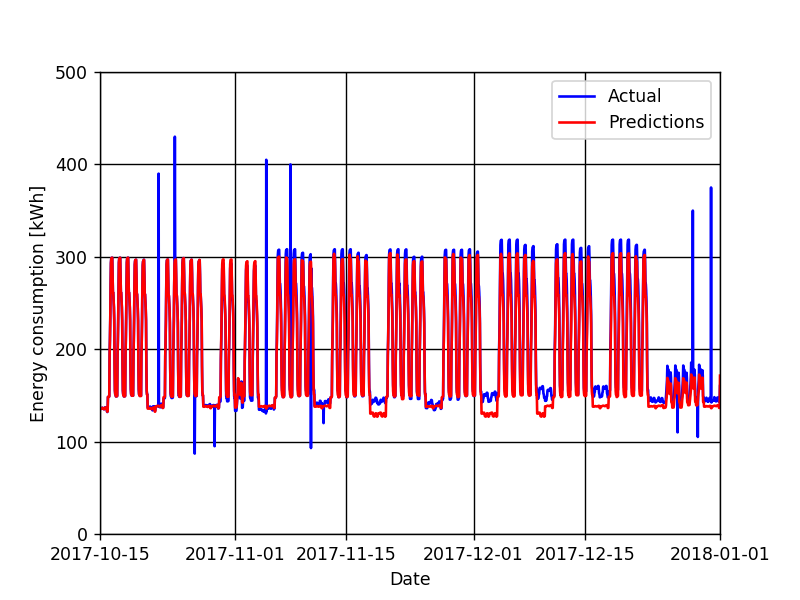

(736617.0, 736695.0)

In [18]:
#plotting Random Forest predictions
plot_predict(data.index,data['Actual'],predictions_rf)
plt.ylim(0,500)
plt.xlim('2017-10-15','2018-1-1')

In [11]:
#Calculates Random Forest Error Metrics
rf_err,rf_per=metrics_error(data['Actual'],predictions_rf,'Random Forest')
rf_err

Random Forest
MAE        1.982943
MSE       60.304213
RMSE       7.765579
MASE       0.158312
MAPE       0.010012

# Search For Outliers

## Using the following methods:

#### - 3-Sigma Rule
#### - BoxPlot
#### - Skewed BoxPlot
#### - Adjusted BoxPlot

##### The functions are described in the file "statistic_out_det.py"

In [12]:
#Looking for outliers directly with the measured data
from outdet.statistic_out_det import detection
global_out,oi,FL=limites(Y1)
detection(Y1,GT_out)

Potential Outliers Detected  True Positives  \
3 Sigma                                    11               3   
MAD                                       808               6   
BoxPlot                                     0               0   
Skewed BoxPlot                              1               1   
Adjusted BoxPlot                           82               6   

                  False Negatives  False Positives  Precision    Recall  \
3 Sigma                         9                8   0.272727  0.250000   
MAD                             6              802   0.007426  0.500000   
BoxPlot                        12                0        NaN  0.000000   
Skewed BoxPlot                 11                0   1.000000  0.083333   
Adjusted BoxPlot                6               76   0.073171  0.500000   

                   F_Score  
3 Sigma           0.260870  
MAD               0.014634  
BoxPlot                NaN  
Skewed BoxPlot    0.153846  
Adjusted BoxPlot  0.127660

In [ ]:
#plot_error_upper(global_out,data,data['Actual'])

In [ ]:
#plot_error_lower(global_out,data,data['Actual'])

## Outlier Detection via Forecast Error

##### The Forecast Error method compares the results of previous regression models with the measurements, resulting in an error. After, it applies the statistical methods for outlier detection on that error.
##### We used the three forecast methods and the four statistic outlier detection methods


### Random Forest

In [13]:
#Random Forest
FE_RF,value_RF,FL_RF=limites(rf_per['Error'])
detection(rf_per['Error'],GT_out)

Potential Outliers Detected  True Positives  \
3 Sigma                                    23              11   
MAD                                      2136              12   
BoxPlot                                  1214              12   
Skewed BoxPlot                           1301              12   
Adjusted BoxPlot                           20              11   

                  False Negatives  False Positives  Precision    Recall  \
3 Sigma                         1               12   0.478261  0.916667   
MAD                             0             2124   0.005618  1.000000   
BoxPlot                         0             1202   0.009885  1.000000   
Skewed BoxPlot                  0             1289   0.009224  1.000000   
Adjusted BoxPlot                1                9   0.550000  0.916667   

                   F_Score  
3 Sigma           0.628571  
MAD               0.011173  
BoxPlot           0.019576  
Skewed BoxPlot    0.018279  
Adjusted BoxPlot  0.687500

<IPython.core.display.Javascript object>


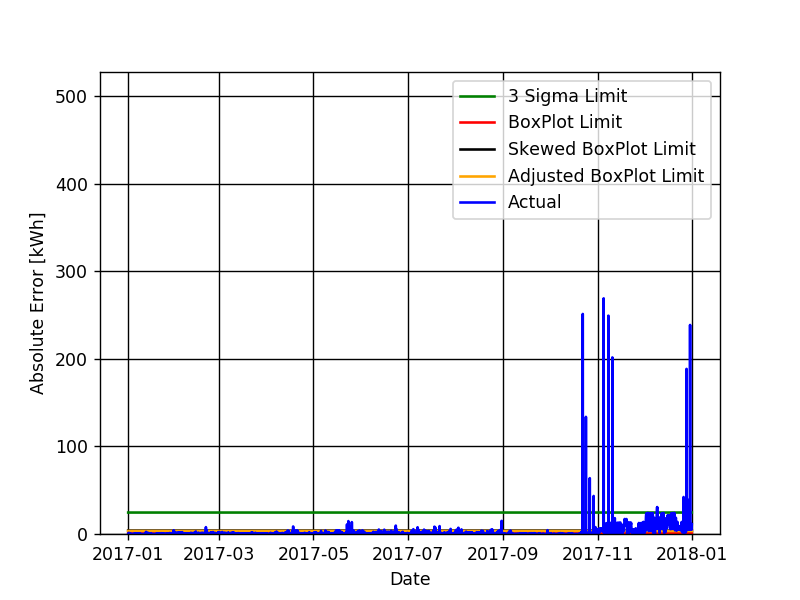

In [19]:
plot_error_upper(FE_RF,data,rf_per['Error'])

<IPython.core.display.Javascript object>


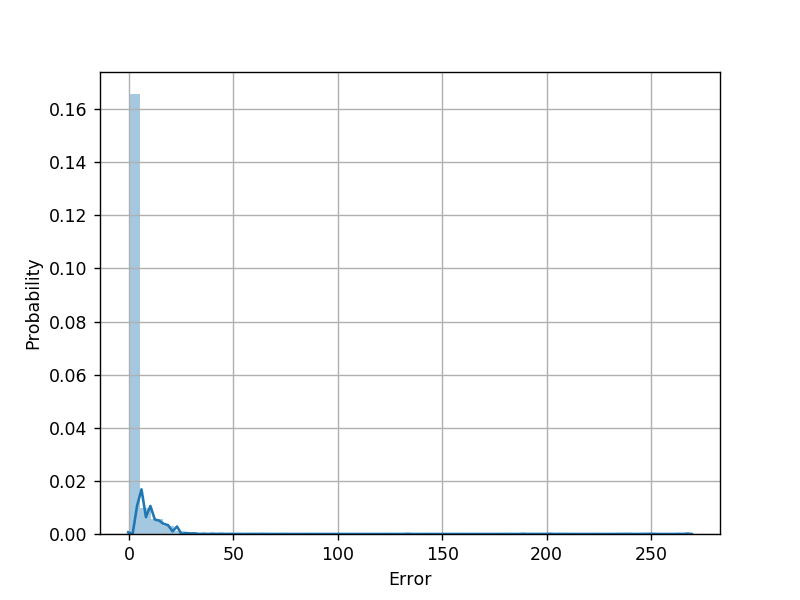

Text(0, 0.5, 'Probability')

In [20]:
#Plotting the error distribution
plt.figure()
sns.distplot(rf_per['Error'])
plt.grid(True)
#plt.ylim(-0.002,0.002)
plt.ylabel('Probability')

In [21]:
rff_resuts=y_test.to_frame()
rff_resuts['Predictions']=predictions_rf
mask = (rff_resuts.index >= '2017-10-20') & (rff_resuts.index <= '2018-1-1')
rff_resuts.loc[mask]
rf_err1,rf_per1=metrics_error(rff_resuts.loc[mask]['Actual'],rff_resuts.loc[mask]['Predictions'],'Random Forest')
rf_err1

Random Forest
MAE        8.363073
MSE      298.365853
RMSE      17.273270
MASE       0.666589
MAPE       0.042703